# Some information on this notebook

Google Colab provides an efficient environment for writing codes collaboratively with your **team mates**.

For us **teachers**, this environment makes it possible to follow your work, whether we are all face-to-face at IMT Atlantique, in hybrid mode, or totally remote.

This notebook offers you a **skeleton** of an ILS meta-heuristics, pre-configured for the use-case on the energy problem.

To collaborate with your team mates on this notebook, you should :

- First **save a copy of this file in your Google Drive**:

  Go to **File** / **Fichier**, then click on **Save a copy in Drive** / **Sauver une copie dans Google Drive**.

- Then, **open that copy**, and **share that copy with your team mates** (and your teacher obviously):

  Click on the top right on **Share** / **Partager**, then in the window **Obtenir le lien**, change the sharing method **Restricted** / **Limité** to **Anyone with the link** / **Tous les utilisateurs disposant du lien**, and change **Viewer** / **Lecteur** to **Editor** / **Editeur**. Finally click on **Copy link** / **Copier le lien**, and share this link with your team mates.

The best is probably to put that link in the header of your Mattermost team, so that your teacher and your team mates can easily find it.

**Before starting to code**, you should execute the first cell below, which helps you to upload the data files (in Excel format) to your notebook. You can also do this by hand, by:

- Clicking on the left on the small **folder icon**,
- Creating a **directory** for the data files (call it data),
- **Uploading** the two Excel files provided in the website (the small and the large problem) in that directory.


# Upload of the data files (do only once !!)

The cell below contains some code to

- **Upload** the Excel files containing the **data** of the problems,
- **Create** a **directory** for those files (we chose to call that directory `data` for some obvious reasons),
- **Move** the data files to the `data` directory,
- **Remove** the `sample_data` directory which is created by default when a new Google Colab notebook is created.

Once executed at the beginning of your work, you can **comment this cell out** (by putting `#` in front of each line), so that it is not executed every time you execute the whole notebook !


In [40]:
"""from google.colab import files
import os
import shutil

uploaded = files.upload()
dest_path = "/content/data/"
os.makedirs(os.path.dirname(dest_path), exist_ok=True)
#shutil.move("/content/InputDataEnergyLargeInstance.xlsx", dest_path)
shutil.move("/content/InputDataEnergySmallInstance.xlsx", dest_path)
shutil.rmtree("/content/sample_data/", ignore_errors=True, onerror=None)"""

'from google.colab import files\nimport os\nimport shutil\n\nuploaded = files.upload()\ndest_path = "/content/data/"\nos.makedirs(os.path.dirname(dest_path), exist_ok=True)\n#shutil.move("/content/InputDataEnergyLargeInstance.xlsx", dest_path)\nshutil.move("/content/InputDataEnergySmallInstance.xlsx", dest_path)\nshutil.rmtree("/content/sample_data/", ignore_errors=True, onerror=None)'

# Imports of modules

Below we import some modules necessary to make this code work properly.

You can add other modules here which you might need for your algorithm.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import random
from scipy.spatial import distance

# Definitions of constants

In the cell below we define some constants that we need in the meta-heuristic.

The paths to the data files are also specified here.

In [42]:
# ILS parameters

MAX_ITER = 100     # maximum number of iterations (Stopping criterion of ILS)
MAX_ITER_NI = 50   # number of iterations without improvement of the objective function (Stopping criterion of ILS)
MAX_ITER_LS = 100  # maximum number of iterations of the local search operator (Outer loop)
MAX_SWAPS = 1      # maximum number of swaps of the local search operator (Inner loop)
NB_SWAPS = 1       # number of swaps in the perturbation operator
ALPHA = 0.06

# Path to data file

#INPUT_DATA = "/content/data/InputDataEnergySmallInstance.xlsx"  # Small instance
INPUT_DATA = "/content/data/InputDataEnergyLargeInstance.xlsx"  # Large instance

# Functions to load and prepare the data

In the cell below, you find three functions:
- first, read_excel_data, which returns the values of a specific sheet in an Excel file,
- then, a function to calculate the length of an eadge A--B in the network based on the coordinates of nodes A and B,
- and finally, create_data_model which fills the data dictionary with the data from the various sheets of the Excel file, as well as some dependent data, which is calculated from the raw data.

In [43]:
def read_excel_data(filename: str, sheet_name: str) -> np.ndarray:
    """Read data from an excel spreadsheet.

    :param filename:
    :param sheet_name:
    :return: sheet data
    """
    data = pd.read_excel(filename, sheet_name=sheet_name, header=None)
    values = data.values
    return values


def compute_edge_lengths(nodes_coord: np.ndarray) -> np.ndarray:
    """Compute distance matrix between each pair of nodes.

    :param nodes_coord: coordinates of each node as a N*2 array
    :return:
    """
    edges_length = np.zeros((len(nodes_coord), len(nodes_coord)))
    for i in range(0, len(nodes_coord)):
        for j in range(0, len(nodes_coord)):
            edges_length[i, j] = distance.euclidean((nodes_coord[i]), (nodes_coord[j]))
    return edges_length


def create_data_model() -> dict:
    """Create the data model which gathers all problem parameters.

    :return: data model structure
    """
    data = {}

    # This section contains all required data #
    data['SourceNum'] = read_excel_data(INPUT_DATA, "SourceNum")[0][0]

    # Nodes Cordinate Read From Excel#
    data['NodesCord'] = read_excel_data(INPUT_DATA, "NodesCord")

    # Building Cordinate Read From Excel#
    #EdgesDemand = read_excel_data(INPUT_DATA, "EdgesDemand")

    # Fixed Unit Cost
    data['FixedUnitCost'] = read_excel_data(INPUT_DATA, "FixedUnitCost")

    # Edges Length Calculation based the Nodes Cordinate
    data['EdgesLength'] = np.matrix.round(compute_edge_lengths(data['NodesCord']))

    # Fixed Instalation cost
    data['cfix'] = data['EdgesLength'] * data['FixedUnitCost']

    # Number of Nodes
    data['node_num'] = len(data['NodesCord'])

    # Revenue of Fulfiling the Edges Demand
    data['crev'] = read_excel_data(INPUT_DATA, "crev(cijrev)")

    # Penalty of Unmet Demand
    data['pumd'] = read_excel_data(INPUT_DATA, "pumd(pijumd)")

    # Cost of Heat Production in the Sources
    data['cheat'] = read_excel_data(INPUT_DATA, "cheat(ciheat)")

    # Variable Cost of Heat Transferring through the Edges
    data['cvar'] = read_excel_data(INPUT_DATA, "cvar(cijvar)")

    # Variable Thermal Losses
    data['vvar'] = read_excel_data(INPUT_DATA, "vvar(thetaijvar)")

    # Fixed Thermal Losses
    data['vfix'] = read_excel_data(INPUT_DATA, "vfix(thetaijfix)")

    # Full Load Hours for the Sources
    data['Tflh'] = read_excel_data(INPUT_DATA, "Tflh(Tiflh)")

    # Concurrence Effect
    data['Betta'] = read_excel_data(INPUT_DATA, "Betta")

    # Connect Quota
    data['Lambda'] = read_excel_data(INPUT_DATA, "Lambda")

    # Annuity Factor for Investment Cost
    data['Alpha'] = read_excel_data(INPUT_DATA, "Alpha")

    # Edges Peak Demand
    data['EdgesDemandPeak'] = read_excel_data(INPUT_DATA, "EdgesDemandPeak(dij)")

    # Edges Annual Demand
    data['EdgesDemandAnnual'] = read_excel_data(INPUT_DATA, "EdgesDemandAnnual(Dij)")

    # Edges Maximum Capacity
    data['Cmax'] = read_excel_data(INPUT_DATA, "Cmax(cijmax)")

    # Cost of Maintenance
    data['com'] = read_excel_data(INPUT_DATA, "com(cijom)")

    # Source Maximum Capacity
    data['SourceMaxCap'] = read_excel_data(INPUT_DATA, "SourceMaxCap(Qimax)")

    # Dependent Parameters
    data['kfix'] = data['cfix'] * data['Alpha'] * data['EdgesLength'] + data['com'] * data['EdgesLength']
    data['kvar'] = data['cvar'] * data['EdgesLength'] * data['Alpha']
    data['rheat'] = data['crev'] * data['EdgesDemandAnnual'] * data['Lambda']
    data['kheat'] = (data['Tflh'] * data['cheat']) / data['Betta']
    data['Etta'] = 1 - data['EdgesLength'] * data['vvar']
    data['Delta'] = data['EdgesDemandPeak'] * data['Betta'] * data['Lambda'] + data['EdgesLength'] * data['vfix']

    return data

# Functions to calculate the objective function from the solution representation

The cell below contains 2 functions to calculate the objective function of an individual:
- first `prufer_to_tree` which transforms the Prüfer representation of a solution into a tree,
- second, `tree_to_prufer` which transforms a tree into a Prüfer representation,
- third, `compute_of` which calculates the fitness (or objective function) of an individual (or a solution).

In [44]:
def prufer_to_tree(prufer_sequence: list) -> nx.Graph:
    """Transform the Prüfer representation into a tree.

    :param a: Prüfer sequence representing a tree
    :return: tree as a graph structure
    """
    return nx.from_prufer_sequence(prufer_sequence)


def tree_to_prufer(tree: nx.Graph) -> list:
    """Transform a tree into a Prüfer sequence.

    :param tree:
    :return: Prüfer sequence representing the tree
    """
    return nx.to_prufer_sequence(tree)


def compute_of(individual: list, data: dict) -> float:
    """Calculate the objective function of the individual.

    :param individual: solution as a tree in Prüfer representation
    :param data: data model including all parameters of the problem
    :return: value of the objective function for given individual
    """
    graph = prufer_to_tree(individual)
    tree_edges = list(graph.edges)
    all_pairs_path = dict(nx.all_pairs_shortest_path(graph))
    path_from_source = all_pairs_path[data['SourceNum']]

    P_in = np.zeros((len(graph.edges)+1, len(graph.edges)+1))
    P_out = np.zeros((len(graph.edges)+1, len(graph.edges)+1))

    hubs = np.unique(individual)#sommets non feuilles de l'arbre
    spokes = list(set([i for i in range(len(individual)+2)]) - set(hubs))#feuilles de l'arbre

    for i in spokes:
        A = path_from_source[i]
        e = 0
        for k in range(0, len(A)-1):
            if e == 0:
                P_out[A[len(A)-k-2], A[len(A)-k-1]] = 0
                e = e + 1
            else:
                P_out[A[len(A)-k-2], A[len(A)-k-1]] = sum(P_in[A[len(A)-k-1]])

            P_in[A[len(A)-k-2], A[len(A)-k-1]] = (P_out[A[len(A)-k-2], A[len(A)-k-1]] + data['Delta'][A[len(A)-k-2], A[len(A)-k-1]])/data['Etta'][A[len(A)-k-2], A[len(A)-k-1]]

    fitness = 0
    metDemand = 0
    for i in range(len(tree_edges)):
        fitness = fitness + data['kfix'][tree_edges[i]] - data['rheat'][tree_edges[i]] + data['kvar'][tree_edges[i]] * (P_in[tree_edges[i][0], tree_edges[i][1]])
        metDemand = metDemand + 2 * data['EdgesDemandAnnual'][tree_edges[i]] * data['pumd'][tree_edges[i]]

    # One source
    fitness = fitness + data['kheat'][data['SourceNum']] * sum(P_in[data['SourceNum']])
    fitness = fitness + 0.5*((data['EdgesDemandAnnual'] * data['pumd']).sum() - metDemand)
    #rappel: notre objectif est de minimiser la fonction objective

    return fitness

# Functions to create solutions or individuals

The cell below contains two functions regarding individuals:

- first, `generate_individual` to create a random individual,
- second, `initial_solution` which returns this single randomly generated individual and its fitness.

In [45]:
def generate_individual(nb_nodes: int) -> list:
    """Generate a random individual.

    The created nodes will be labelled as integer from 0 to `nb_nodes`-1

    :param nb_nodes: total number of nodes in an individual tree
    :return: Prüfer representation of a random tree with given number of nodes
    """
    individual = np.ndarray.tolist(np.random.randint(0, high=nb_nodes-1, size=nb_nodes-2, dtype='int'))

    return individual


def initial_solution(data: dict) -> tuple:
    """Generate a random solution and calculate its fitness.

    :param data: data model including all parameters of the problem
    :return: random solution in Prüfer representation, and its objective function value
    """
    # here we are generating only one initial solution
    solution = generate_individual(data['node_num'])
    return solution, compute_of(solution, data)

# Functions for the local search

Below you can find functions to perform a local search:
- first the general high-level `local_search` function,
- second the `swap` function, which implements a swap operator,
- third the `swap_neighborhood` function which generates the neighborhood based on the swap operator,
- and finally the `unique_pairs` function, used by `swap_neighborhood`, wich generates unique pairs indexes.

In [46]:
def local_search(sol: list, of: float, data: dict) -> tuple:
    """Perform a local search.

    :param sol: input solution
    :param of: objective function value of input solution
    :param data: data model including all parameters of the problem
    :return: best neighbouring solution, and its objective function value
    """
    # number of iterations local search
    nb_iterations = 0

    best_of = of
    best_sol = sol

    # Main loop local search
    # Local search operators is repeated MAX_ITER_LS times
    while nb_iterations <= MAX_ITER_LS:

        nb_iterations += 1

        # use an operator to perform local search

        # Random restart
        s0, s0_of = initial_solution(data)
        neighbors, _ = swap_neighborhood(s0, s0_of, data)

        for neighbor in neighbors:
            #print(neighbor)
            neighbor_of = compute_of(neighbor, data)
            if neighbor_of < s0_of:
                s0, s0_of = neighbor, neighbor_of

        # if s0 is better than best_sol
        if s0_of < best_of:
            best_of, best_sol = s0_of, s0

    return best_sol, best_of


def swap(i: int, j: int, sol: list) -> list:
    """Swap operator.

    This function simply swaps the nodes at position `i` and `j` in the Prüfer sequence.

    :param i: first position in `sol` sequence
    :param j: second position in `sol` sequence
    :param sol: parent solution to modify
    :return: new solution
    """

    new_sol = sol.copy()
    new_sol[i], new_sol[j] = new_sol[j], new_sol[i]

    return new_sol


# The following function is a function to generate the neighbours of the given solution "sol"
def swap_neighborhood(sol: list, best_of: float, data: dict) -> tuple:
    """Neighborhood generation with a swap operator.

    All pairs of possible neighbours are investigated and create a solution and its objective function value each.

    :param sol: parent solution which neighbourhood to search
    :param best_of: parent solution objective function value
    :param data: data model including all parameters of the problem
    :return: list of neighbouring solutions, and corresponding list of neighbours objective function values
    """

    n = []
    of = []
    N = len(sol)

    for i, j in unique_pairs(N):
        neighbor = swap(i, j, sol)
        n.append(neighbor)
        of.append(compute_of(neighbor, data))

    return n, of


def unique_pairs(n: int):
    """Generator producing pairs of indexes in range(n).

    :param n:
    :return: pair of indexes (generator)
    """
    for i in range(n):
        for j in range(i + 1, n):
            yield i, j

# Functions for the perturbation of solutions

In [47]:
def random_swap(sol: list) -> list:
    """Random perturation.

    Applies `NB_SWAPS` random swap operations on the solution.

    :param sol: parent solution
    :return: modified solution
    """

    for k in range(NB_SWAPS):
        i = np.random.randint(0, len(sol)-1)
        j = np.random.randint(0, len(sol)-1)
        sol = swap(i, j, sol)

    return sol

# This function is the main body of the perturbation operator, wherein the random_swap function is called
def perturb(sol: list, data: dict) -> tuple:
    """Add random perturbations on the solution.

    :param sol: current solution to modify
    :param data: data model including all parameters of the problem
    :return: new solution, and its objective function value
    """

    pert_sol = random_swap(sol)
    pert_of = compute_of(pert_sol, data)

    return pert_sol, pert_of

# Main


Random solution
Initial objective function value: [1.13811055e+09]
Solution: [28, 20, 15, 21, 16, 23, 20, 24, 27, 8, 22, 21, 2, 11, 1, 25, 27, 2, 7, 6, 4, 17, 19, 14, 28, 28, 2, 6]

Local Search
Objective function value: [7.4200999e+08]
Tour: [19, 19, 14, 6, 10, 12, 24, 26, 17, 14, 14, 19, 4, 9, 7, 18, 18, 23, 26, 5, 16, 6, 9, 5, 13, 15, 13, 17]
Graph with 30 nodes and 29 edges


After 6  ILS iterations, the best solution is:
[23, 17, 1, 11, 16, 26, 12, 5, 21, 7, 24, 15, 9, 16, 11, 20, 24, 18, 1, 22, 8, 14, 25, 0, 23, 14, 21, 14]
with total cost: [6.87831782e+08]


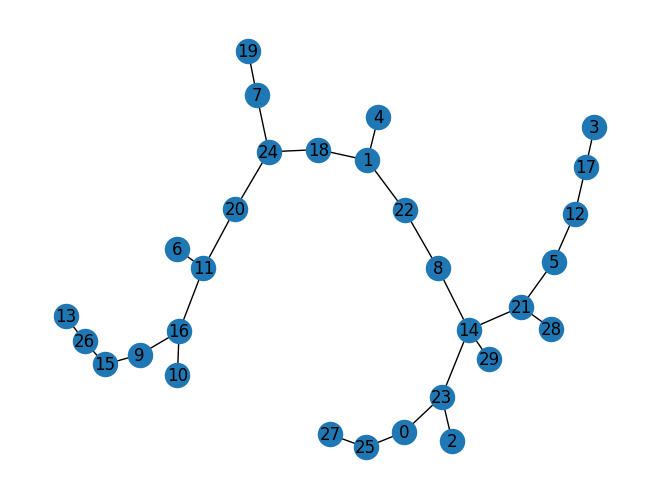

In [48]:
if __name__ == "__main__":
    # *************************Initialisation***************************
    # initialise the data
    data = create_data_model()

    # init number of iterations
    nb_iterations = 0

    # find initial solution (just one) with a constructive heuristic
    best_sol, best_of = initial_solution(data)

    # ********************************************************************

    print("Random solution")
    print("Initial objective function value:", best_of)
    print("Solution:", best_sol)

    # **************************Local Search******************************

    best_sol, best_of = local_search(best_sol, best_of, data)
    best_known = best_sol
    best_of_known = best_of

    print("\nLocal Search")
    print("Objective function value:", best_of)
    print("Tour:", best_sol)

    best_solution = prufer_to_tree(best_sol)

    print(best_solution)

    # ********************************************************************

    # ******************************ILS***********************************
    flag_continue = True
    improve = 0

    while flag_continue and nb_iterations <= MAX_ITER and improve <= MAX_ITER_NI:

        nb_iterations += 1
        # ******************Perturbation**********************************
        pert_sol, pert_of = perturb(best_sol, data)
        # print(pert_of)

        # ******************Local Search***********************************
        best_sol_pert, best_of_pert = local_search(pert_sol, pert_of, data)
        # print(best_of_pert)

        # ******************Aceptance criterion***************************
        if (best_of_pert < best_of_known):
            best_known = best_sol_pert
            best_of_known = best_of_pert
            improve = 0
        else:
            improve += 1

        if (best_of_pert < best_of * (1 + ALPHA)):
            best_of = best_of_pert
            best_sol = best_sol_pert
        else:
            flag_continue = False

    print("\n")
    print("After", nb_iterations, " ILS iterations, the best solution is:")
    print(best_known)
    print("with total cost:", best_of_known)

    best_solution = prufer_to_tree(best_known)

    graph = nx.Graph(best_solution)
    plt.figure(2)
    nx.draw(graph, with_labels=True)
    plt.show()

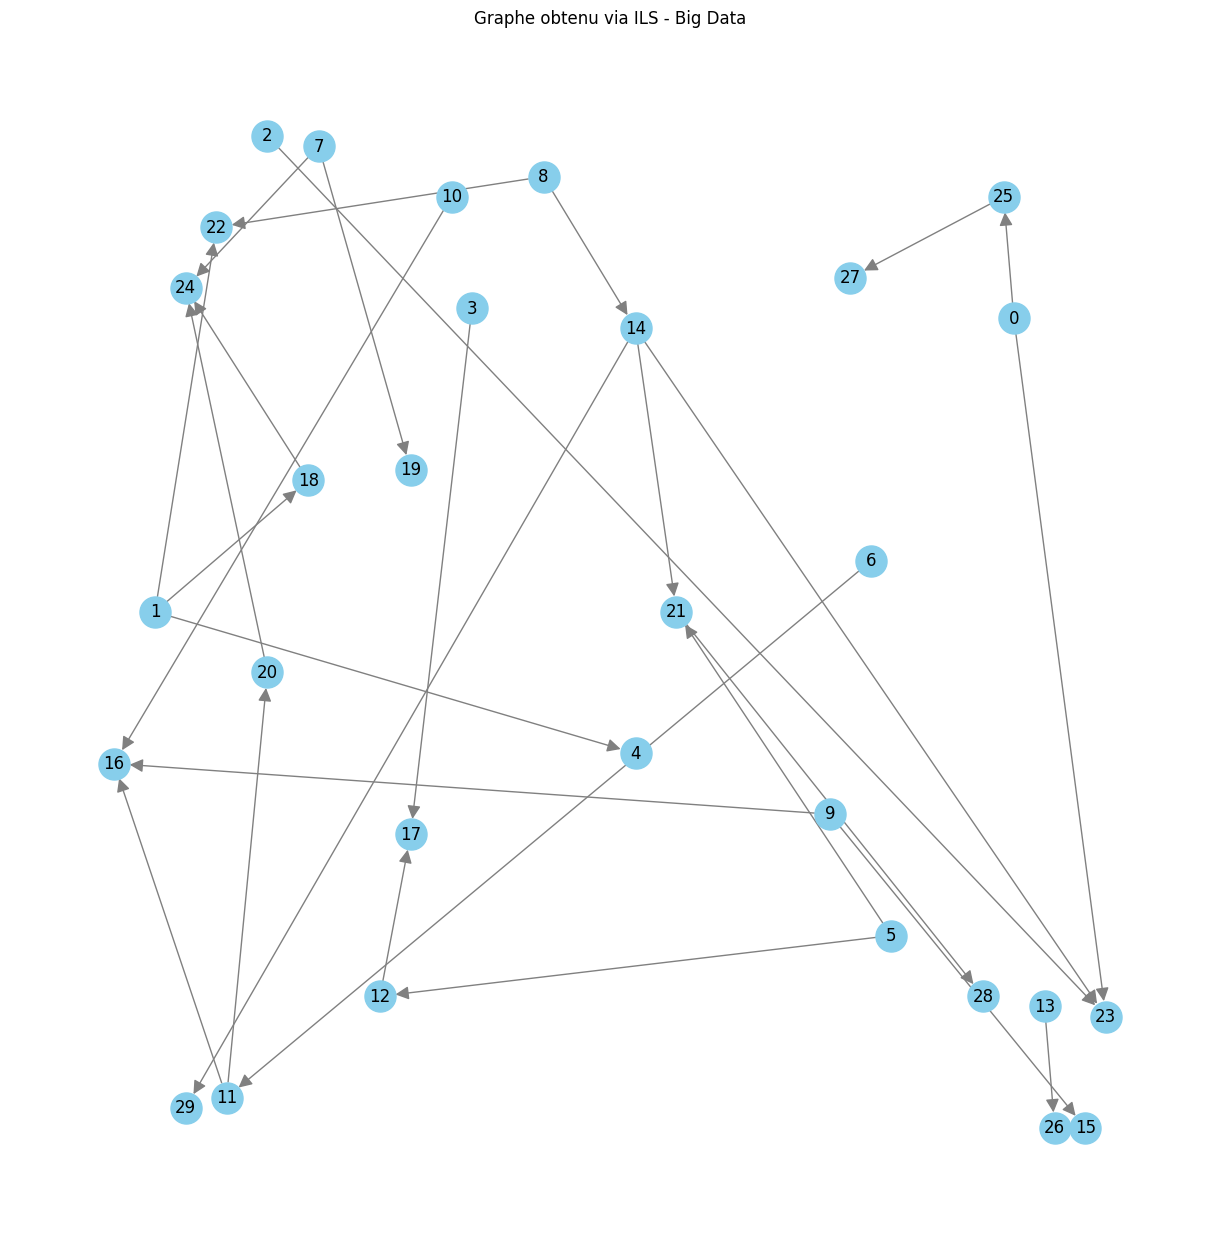

In [49]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming 'data' is accessible from previous cells and contains 'NodesCord'
# If not, you need to load it appropriately
tree = prufer_to_tree(best_known)
NodesCord = data['NodesCord']  # Access NodesCord from the 'data' dictionary
# Convert NodesCord to a dictionary if necessary
NodesCord = {i: coord for i, coord in enumerate(NodesCord)}  # Assuming node indices are 0, 1, 2...

# Then, get the edges from the tree
edges = list(tree.edges)

# Now you can create the graph and add the edges
G = nx.DiGraph()
G.add_edges_from(edges)

# Ajouter les nœuds si ce n’est pas déjà fait par les arêtes
G.add_nodes_from(NodesCord.keys())  # Pour s’assurer que tous les nœuds sont présents

# Extraire les positions à partir de NodesCord
pos = {node: (float(NodesCord[node][0]), float(NodesCord[node][1])) for node in NodesCord}

# Tracer le graphe
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True,  node_color='skyblue', node_size=500,
        edge_color='gray', arrows=True, arrowsize=20)
plt.title("Graphe obtenu via ILS - Big Data")
plt.show()